In [ ]:
import sys
sys.path.insert(1, r"/vol/bitbucket/mjh24/IAEA-thesis")
import os
os.environ.setdefault("HF_HOME", "/data/mjh24/hf")
os.environ.setdefault("TRANSFORMERS_CACHE", "/data/mjh24/hf/transformers")
os.makedirs(os.environ["TRANSFORMERS_CACHE"], exist_ok=True)
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
from Stage1.GAT.GATModel import GraphAttentionNetwork
from Single_Website_Download.Download import main as downloadHTML
import torch
from Stage1.ExtractingGraphs.seleniumDriver import *
from Stage2.txtGraphExtraction.extract_mini_txt_graphs_helper import *
from Stage2.txtGraphExtraction.extract_mini_txt_graphs_helper import main as txtExtractor
from Stage1.tree_helpers import *
from Stage2.txtGraphPruning.display_txt_graph import draw_graph_from_arrays
from Stage2.txtGraphPruning.prune_txt_graph import main as prune_txt_graph
from Stage2.txtGraphPruning.graph_clustering import leiden_clustering, mini_graphs_from_clusters, louvain_clustering
from Stage2.classifyingEdges.classifyingFLANT5 import clean_instructional_text, classify_link_pairs_flan_batched
from Stage2.classifyingEdges.classifyingDeBerta import classify_node_isSentence, classify_node_isCatgory
from Stage2.classifyingEdges.rewritingOPENAI import add_context, summairse, summairse_clusters
from Stage2.classifyingEdges.classifyingOpenAI import classify_needsContext_openAI, classify_link_pairs_openAI, classify_pairwiseEdges_openAI
from Stage2.classifyingEdges.metrics import metrics
from itertools import combinations
from collections import defaultdict
from pathlib import Path
import numpy as np

CLIP_TO_N_EDGES_PER_NODE = 10 # This is to clip all the outgoing edges per node to a certain number
device = device or ("cuda" if torch.cuda.is_available() else "cpu")
REMOVE_DUPES = False

/vol/bitbucket/mjh24/IAEA-thesis/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/vol/bitbucket/mjh24/IAEA-thesis/.venv/lib/python3.12/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


Note: to be able to use all crisp methods, you need to install some additional packages:  {'bayanpy', 'wurlitzer', 'infomap', 'graph_tool'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'pyclustering', 'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'infomap'}


### Step 1. ###
Load the model and download the website

In [2]:
# Load model
# model = GraphAttentionNetwork(in_dim = 119, edge_in_dim = 210, edge_emb_dim = 32, hidden1 = 32, hidden2 = 32, hidden3 = 8, heads = 2)
# state_dict = torch.load("/vol/bitbucket/mjh24/IAEA-thesis/Stage1/GAT/LONG80EPOCH-75f1-newlabelnotitle.pt", map_location=torch.device(device))
model = GraphAttentionNetwork(in_dim = 119, pe_dim=11, edge_in_dim = 210, edge_emb_dim = 32, heads = 4)
state_dict = torch.load("/vol/bitbucket/mjh24/IAEA-thesis/TrueTransformer-newtagsnotitle.pt", map_location=torch.device(device))
model.load_state_dict(state_dict, strict=False)
model.to(device)

# Load the website
htmlFile = "/vol/bitbucket/mjh24/IAEA-thesis/data/swde/sourceCode/sourceCode/movie/movie/movie-allmovie(2000)/0000.htm"
# url = r"https://www.nucnet.org/news/parliament-resolution-paves-way-for-establishing-nuclear-energy-legislation-6-4-2024"
# url = "https://westinghousenuclear.com/"
# url = "https://www.football.co.uk/news/leeds-vs-bournemouth-premier-league-team-news-lineups-prediction/781112/"
# url = r"https://www.bbc.co.uk/news/live/cev28rvzlv1t"
# url = "https://www.nfl.com/teams/" # Great to show teams and structured data
# url = "https://www.energy.gov/ne/articles/advantages-and-challenges-nuclear-energy" #Great to show semi structured webpages with titles
# url = "https://westinghousenuclear.com/nuclear-fuel/fuel-fabrication-operations/"
# url = "https://www.livescore.com/en/football/england/premier-league/bournemouth-vs-leicester-city/1250940/lineups/"
#htmlFile = Path("/vol/bitbucket/mjh24/IAEA-thesis/data/websites/test.html")
#downloadHTML(url,1,htmlFile)

### Step 2. ###
Apply the graph model to extract all the possible edges.
This extracts all text nodes found and outputs all possible edges, along with their probabilities

In [3]:
# Get label edges from text nodes in the website
sorted_label_index_extracted, xpaths_extracted, txts_extracted, probs_extracted, title_label, title_txt, title_xpaths, title_probs = txtExtractor(htmlFile, model, alreadyConvertedToGraph="/vol/bitbucket/mjh24/IAEA-thesis/data/0000_test", remove_dupes=REMOVE_DUPES)
#sorted_label_index_extracted, xpaths_extracted, txts_extracted, probs_extracted, title_label, title_txt, title_xpaths, title_probs = txtExtractor(htmlFile, model, remove_dupes=REMOVE_DUPES)
model.to("cpu")         # offload to CPU
if torch.cuda.is_available():
    torch.cuda.empty_cache() # reclaim GPU cache

In [4]:
for i in range(len(title_txt)):
    print(title_txt[i], title_probs[i])

Terms of Service 0.95352507
High Production Values 0.8267906
Donald Byrd (1932) 0.7597109
John Cassavetes (1929) 0.5989724
The Sweet Hereafter 0.58127433
» In the Spotlight 0.40894887
Privacy Policy 0.32439584
» New Releases 0.29720515
» Glossary 0.13245702
Overview 0.047870275
Product Submissions 0.040303208
High Artistic Quality 0.03405288
Plot Synopsis 0.02318224
Review 0.014879067
Employment 0.011113127
Advertising 0.009759658
V   155010 0.005416213
Is related to: 0.0036818974
Cast 0.0031126433
R 0.002982446
for sexuality and some language 0.002552399
Countries 0.002508912
Year 0.0020176289
Category 0.0019495181
Canada 0.0014235523
British Columbia, Canada 0.0012709317
In a Minor Key 0.0012557367
by Jason Ankeny 0.0012529315
Douglas Fairbanks, Jr. (1909) 0.0011859089
Panavision 0.0011456913
Drama 0.0010750946
Feature 0.0008887165
1997 0.0008428454
» AllMovie Blog 0.0005998902
Run Time 0.00054489763
Color Type 0.0005339022
» Essays 0.000531454
Color 0.00047295
110 min. 0.00044902065

In [5]:
# Normalise the text
normtxt = []
for a, b in txts_extracted:
    normtxt.append([normalise_text(a, ",:\\-.%'\\s", lower=False), normalise_text(b, ",:\\-.%'\\s", lower=False)])
txts, probs, sorted_label_index, xpaths = np.array(normtxt), np.array(probs_extracted), np.array(sorted_label_index_extracted), np.array(xpaths_extracted)

Extract unique nodes from the edges and create a mapping from node to edge

In [6]:
node_unique_label_index, node_to_edge_pos = np.unique(sorted_label_index, return_index=True)
node_to_edge_pos = np.array([[int(idx/2),0] if idx%2==0 else [int(idx/2),1] for idx in node_to_edge_pos])
node_to_edge_x_pos, node_to_edge_y_pos = node_to_edge_pos[:,0], node_to_edge_pos[:,1]

node_unique_txts, node_unique_xpaths = txts[node_to_edge_x_pos,node_to_edge_y_pos], xpaths[node_to_edge_x_pos, node_to_edge_y_pos]

### Step 3. ###
This filters out all the nodes where the text is a button/navigational link.

This uses a FLAN-T5 model

In [7]:
# Remove all html instructional labels
txtsShortened = [[a.split(".")[0], b.split(".")[0]] for a, b in txts]
isButton, buttonTxt = clean_instructional_text(txtsShortened, batch_size=16)
opmask = np.array(isButton, dtype=bool)
mask = np.logical_not(opmask)

print("All the nodes filtered out:\n\n")
isButtonNode = np.zeros_like(node_unique_txts, dtype=bool)
for key, value in buttonTxt.items():
    if value == 1:
        idx = np.where(node_unique_txts==key)
        print(len(idx[0]),"-",key)
        isButtonNode[idx] = True

All the nodes filtered out:


1 - Contact
1 - Category
1 - Send to Friend
1 - About Us
1 - Privacy Policy
1 - View DVD Releases


In [8]:
txts, probs, sorted_label_index, xpaths = txts[mask], probs[mask], sorted_label_index[mask], xpaths[mask]
node_unique_label_index, node_to_edge_pos, node_unique_txts, node_unique_xpaths = node_unique_label_index[~isButtonNode], node_to_edge_pos[~isButtonNode], node_unique_txts[~isButtonNode], node_unique_xpaths[~isButtonNode]

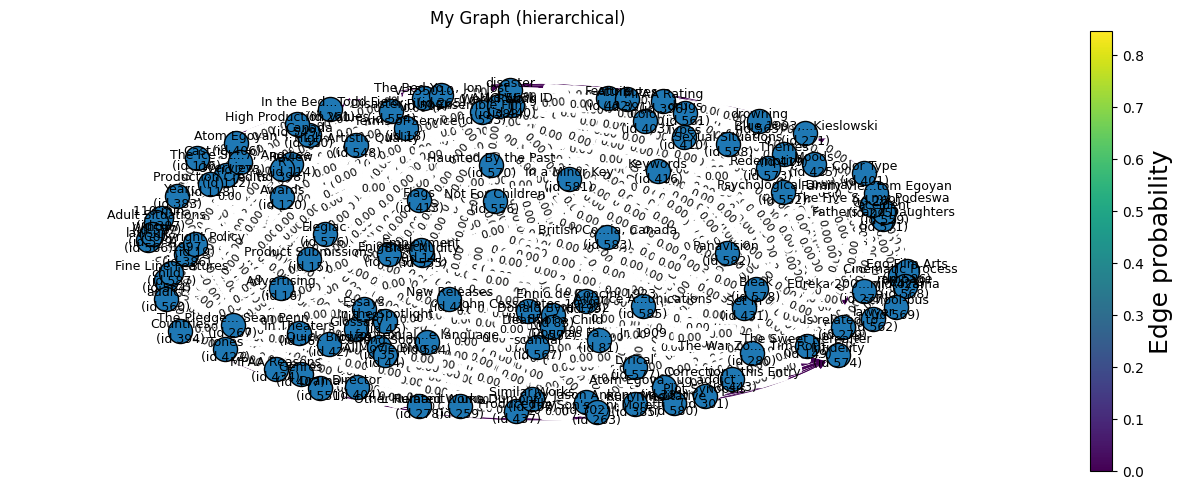

In [ ]:
# Displaying the graph before all the pruning steps
_=draw_graph_from_arrays(
    txt_edge_pairs=txts,
    id_edge_pairs=sorted_label_index,
    xpath_edge_pairs=xpaths,
    probs=probs,
    layout="spring",
    rankdir="TB",         # or "TB" for top→bottom
    layer_spacing=1.5,    # spread layers further
    node_spacing=10,     # spread nodes within a layer
    figsize=(12, 5),
    title="My Graph (hierarchical)",
    draw_edge_labels=False
)

### Step 4. ###
This filters out all the low probability edges using the finding from the probability paper. At least two edges per node are saved

In [10]:
# -- RUN THE MAIN PRUNING MASK --
mask = prune_txt_graph(probs, sorted_label_index, toloerance=0.01, remove_dupes=REMOVE_DUPES)

# Concatanate and apply masks if we want specific text
mask = np.array(mask, dtype=bool) 
print(len(sorted_label_index), " -> ", len(sorted_label_index[mask]))
[print(edge) for edge in txts[~mask]]
txts, probs, sorted_label_index, xpaths = txts[mask], probs[mask], sorted_label_index[mask], xpaths[mask]
# -- PRUNING FINISHED --

11556  ->  270
['In Theaters' 'Quick Browse']
['In Theaters' 'In the Spotlight']
['Coming Soon' 'Quick Browse']
['In the Spotlight' 'John Cassavetes 1929']
['Glossary' 'Quick Browse']
['New Releases' 'AllMovie Blog']
['New Releases' 'John Cassavetes 1929']
['AllMovie Blog' 'In Theaters']
['In Theaters' 'AllMovie Blog']
['Advertising' 'New Releases']
['Glossary' 'AllMovie Blog']
['AllMovie Blog' 'Coming Soon']
['Coming Soon' 'AllMovie Blog']
['Advertising' 'In the Spotlight']
['In the Spotlight' 'Donald Byrd 1932']
['In the Spotlight' 'Ennio de Concini 1923']
['Employment' 'New Releases']
['Employment' 'In the Spotlight']
['Donald Byrd 1932' 'New Releases']
['New Releases' 'Donald Byrd 1932']
['Copyright Policy' 'New Releases']
['Product Submissions' 'New Releases']
['Advertising' 'Glossary']
['John Cassavetes 1929' 'Glossary']
['Glossary' 'John Cassavetes 1929']
['Copyright Policy' 'In the Spotlight']
['Product Submissions' 'In the Spotlight']
['Ennio de Concini 1923' 'New Releases']
[

### Step 5. ###
This filters out all the edges where the two text nodes make no sense together (i.e. they talk about different things)

In [11]:
# Classify the edges
#classificationDeBerta, scoresDeberta = classify_link_pairs_zero_shot(txts, batch_size=64, confidence_Factor=0.9, return_scores=True)
#classificationDeBerta_twostep = classify_link_pairs_zero_shot_two_step(txts, batch_size=64, return_scores=False)
classificationFlan = classify_link_pairs_flan_batched(txts, batch_size=32)
#classificationOpenAI = classify_link_pairs_openAI(txts[:40])
#print(classificationDeBerta)
#print(classificationFlan)
#print(classificationDeBerta_twostep)
#print(classificationOpenAI)


In [12]:
#Quick informal test
# y_true_str = "2 2 1 1 ? ? ? ? 3 3 1 1 3 3 2 2 2 2 1 1 ? ? 1 1 3 3 1 1 3 3 1 1 1 1 2 2 2 2 2 2"
# #classificationOpenAI = [1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 1, 1, 3, 3, 3, 1]
# y_true = [3 if tok == "?" else int(tok) for tok in y_true_str.split()]

In [13]:
#metrics(classificationDeBerta[:len(y_true)], y_true)
#metrics(classificationFlan[:len(y_true)], y_true)
#metrics(classificationDeBerta_twostep[:len(y_true)], y_true)
#metrics(classificationOpenAI[:len(y_true)], y_true)

In [14]:
# if len(classificationFlan) != len(txts):
#     raise Exception("The classification is not the same length as the number of edges")
# for (pair, lab) in zip(txts, classificationFlan):
#         print(lab, pair)

#for (pair, lab, sc) in zip(txts, classificationDeBerta, scoresDeberta or []):
#        print(lab, pair, "| scores:", {k: round(v, 3) for k, v in sc.items()})

In [15]:
mask = np.array([(False if i==3 else True) for i in classificationFlan])
print("Removing the following edges:\n\n", txts[~mask])
txts, probs, sorted_label_index, xpaths = txts[mask], probs[mask], sorted_label_index[mask], xpaths[mask]

Removing the following edges:

 [['Essays' 'Quick Browse']
 ['Quick Browse' 'In Theaters']
 ['Cast' 'Production Credits']
 ['Cast' 'Awards']
 ['Sexual Situations' 'Flags']
 ['Employment' 'Copyright Policy']
 ['John Cassavetes 1929' 'Copyright Policy']
 ['Donald Byrd 1932' 'Terms of Service']
 ['John Cassavetes 1929' 'Terms of Service']
 ['Year' '110 min.']
 ["Atom Egoyan's haunting adaptation of the Russell Banks novel The Sweet Hereafter was the Canadian filmmaker's most successful film to date, taking home a Special Grand Jury Prize at the 1997 Cannes Film Festival and scoring a pair of Academy Award nominations, including Best Director. Restructured to fit Egoyan's signature mosaic narrative style, the story concerns the cultural aftershocks which tear apart a small British Columbia town in the wake of a school-bus accident which leaves a number of local children dead. Ian Holm stars as Mitchell Stephens, a big-city lawyer who arrives in the interest of uniting the survivors to init

### 6. Finding each node that needs context to make a complete fact ###

    1) It uses DeBERTa-v3 model to split the nodes into more than a phrase and less that a phrase

For those that are <b> more than a phrase </b>

    2.1) GPT_4.1_mini decides if the sentences need more context

For those that are <b> less than a phrase </b>

    2.2) Use DeBERTa to categorise the value

The reason they are split is that it is a lot easier to create sentences from small "value to value" pairs. It is also good as the "value to sentence" edges are easier to extract information from if we know which are sentences (that need context) and which are values (that give context).

In [16]:
isSentence, isSentence_probs = classify_node_isSentence(node_unique_txts.tolist(), batch_size=32)
for isS, txt in zip(isSentence, node_unique_txts):
    print(isS, txt)

0 Employment
0 Product Submissions
0 Advertising
0 Terms of Service
0 Copyright Policy
0 Coming Soon
0 In Theaters
0 Essays
0 Glossary
0 New Releases
0 Quick Browse
0 AllMovie Blog
0 In the Spotlight
0 Ennio de Concini 1923
0 Douglas Fairbanks, Jr. 1909
0 Donald Byrd 1932
0 John Cassavetes 1929
0 Overview
0 Review
0 Cast
1 Production Credits
0 Awards
0 The Sweet Hereafter
0 Similar Works
0 L'Humanit 1999, Bruno Dumont
0 In the Bedroom 2001, Todd Field
1 The Son's Room 2001, Nanni Moretti
1 The Bed You Sleep In 1993, Jon Jost
0 The Pledge 2001, Sean Penn
0 Family Viewing 1987, Atom Egoyan
0 Blue 1993, Krzysztof Kieslowski
0 The Ice Storm 1997, Ang Lee
1 The Five Senses 1999, Jeremy Podeswa
0 Eureka 2000, Shinji Aoyama
0 Other Related Works
0 Is related to:
0 The War Zone 1999, Tim Roth
1 Plot Synopsis
0 by Jason Ankeny
1 Atom Egoyan's haunting adaptation of the Russell Banks novel The Sweet Hereafter was the Canadian filmmaker's most successful film to date, taking home a Special Grand 

In [17]:
isSentence = np.array(isSentence, dtype=bool)
node_sentences, node_sentences_xpaths = node_unique_txts[isSentence], node_unique_xpaths[isSentence]
if len(node_sentences) > 0:
    ####################################################################################################################Random to not waste money
    #sentenceNeedsContext = np.random.randint(2, size=node_sentences.shape)#
    sentenceNeedsContext, cost_needsContext, _ = classify_needsContext_openAI(node_sentences, dry_run_confirm=False, batch_size=1, return_raw_response_and_cost=True)
    ####################################################################################################################
    sentenceNeedsContext=np.array(sentenceNeedsContext, dtype=bool)
    #Re padding and getting back to the dimension of node_unique_txts
else:
    sentenceNeedsContext, cost_needsContext = np.zeros(node_sentences.shape, dtype=bool), 0
padded_sentenceNeedsContext = np.zeros(isSentence.shape, dtype=bool)
padded_sentenceNeedsContext[isSentence] = sentenceNeedsContext
print("Sentences that need context: ", node_unique_txts[padded_sentenceNeedsContext])




Batch 0 ~input tokens=103, ~output tokens=2, est. cost=$0.0004 (IN=$0.4/1M, OUT=$1.6/1M)
Total_tokens= 99  {input_tokens= 97  reasoning_tokens= 0  output_tokens= 2 }
Running Total cost: $ 4.2000000000000004e-05  This batch cost: $ 4.2000000000000004e-05
output so far:  [NEWBATCH]0
results so far:  [0]

Batch 1 ~input tokens=113, ~output tokens=2, est. cost=$0.0004 (IN=$0.4/1M, OUT=$1.6/1M)
Total_tokens= 109  {input_tokens= 107  reasoning_tokens= 0  output_tokens= 2 }
Running Total cost: $ 8.800000000000001e-05  This batch cost: $ 4.600000000000001e-05
output so far:  [NEWBATCH]0[NEWBATCH]0
results so far:  [0, 0]

Batch 2 ~input tokens=113, ~output tokens=2, est. cost=$0.0004 (IN=$0.4/1M, OUT=$1.6/1M)
Total_tokens= 109  {input_tokens= 107  reasoning_tokens= 0  output_tokens= 2 }
Running Total cost: $ 0.000134  This batch cost: $ 4.600000000000001e-05
output so far:  [NEWBATCH]0[NEWBATCH]0[NEWBATCH]0
results so far:  [0, 0, 0]

Batch 3 ~input tokens=113, ~output tokens=2, est. cost=$0.

In [18]:
node_words = node_unique_txts[~isSentence]
node_words_isCatgory, (_, bestCategory) = classify_node_isCatgory(node_words.tolist())
for idx, (isC, word) in enumerate(zip(node_words_isCatgory, node_words)):
    if not isC:
        bestCategory[idx] = ""
        #print("XX ", word, " XX")
    else:
        pass#print(word, "\t\t->", bestCategory[idx])

padded_node_words_isCatgory = np.zeros(isSentence.shape, dtype=int)
padded_bestCategory =  np.full(isSentence.shape, "", dtype=object)
padded_node_words_isCatgory[~isSentence] = node_words_isCatgory
padded_bestCategory[~isSentence] = bestCategory
for idx, (isC, word) in enumerate(zip(padded_node_words_isCatgory, node_unique_txts)):
    if not isC:
        padded_bestCategory[idx] = ""

### 7a. Focus on Sentences that need Context ###
This decides which sentences to send off for context addition.

Current Sentence filters:
1) isButton
2) isSentence that needs context

<i>(note snall fact nodes will be dealt with through a different pipeline. They go through a different process)</i>

In [19]:
padded_sentenceNeedsContext = np.array(padded_sentenceNeedsContext, dtype=bool)
node_label_NeedsContext = node_unique_label_index[padded_sentenceNeedsContext]
mask = np.isin(sorted_label_index[:,0], node_label_NeedsContext)
needsContext_text_edges, needsContext_xpaths = txts[mask], xpaths[mask]

print("Sentences being checked:")
for idx, isC in enumerate(padded_sentenceNeedsContext):
    if isC:
        print(node_unique_txts[idx])

Sentences being checked:


In [20]:
# Compute all pairwise-edges
# Creating an array of [SENTENCE, CTX1, CTX2] to compare them

outputs_by_input = {}
for inp, out in needsContext_text_edges:
    outputs_by_input.setdefault(inp, []).append(out)

needsContext_allPairwise_text = []
for inp, outs in outputs_by_input.items():
    if len(outs) < 2:
        continue  # need at least two outputs to form a pair

    pair_iter = combinations(outs, 2)
    for c1, c2 in pair_iter:
        needsContext_allPairwise_text.append([inp, c1, c2])
needsContext_allPairwise_text = np.array(needsContext_allPairwise_text)
print(len(needsContext_allPairwise_text))
print(needsContext_text_edges)

0
[]


In [21]:
print(needsContext_text_edges)

[]


In [22]:
BATCH_SIZE = 4
# expects: needsContext_allPairwise_text = [[INPUT, OUT1, OUT2], ...]

# Work on a mutable copy; keep as generic objects (strings/ints/etc.)
remaining = [list(t) for t in needsContext_allPairwise_text]
removedEdges = []

def _choose_smaller(inp, o1, o2):
    prob_1 = probs[((txts[:,0] == inp) & (txts[:,1] == o1))][0]
    prob_2 = probs[((txts[:,0] == inp) & (txts[:,1] == o2))][0]
    if prob_1 < prob_2: return o1
    if prob_2 < prob_1: return o2
    # tie
    return None  # "keep" => don't drop on ties

runningCost_pairwiseEdges = 0
while remaining:
    batch = remaining[:BATCH_SIZE]
    labels, cost, _ = list(classify_pairwiseEdges_openAI(batch, False, 4, True))
    runningCost_pairwiseEdges += cost
    print("Running cost: $", runningCost_pairwiseEdges)
    if len(labels) != len(batch):
        raise ValueError("Classifier must return one label per triplet in the batch.")

    # Advance the window
    remaining = remaining[len(batch):]

    # For any label==0, note which outputs to drop for that INPUT
    drop_by_input = defaultdict(set)

    for triplet, y in zip(batch, labels):
        inp, o1, o2 = triplet
        print(o1)
        print(o2)
        print(y)
        print()
        if y == 0: # 0 means o1 and o2 are similar
            small = _choose_smaller(inp, o1, o2)
            if small:
                drop_by_input[inp].add(small)
                
                # Remove [inp, small] from the array edges we are considering
                mask = ~((needsContext_text_edges[:,0] == inp) & (needsContext_text_edges[:,1] == small))
                removedEdges.extend(needsContext_text_edges[~mask])
                needsContext_text_edges, needsContext_xpaths = needsContext_text_edges[mask], needsContext_xpaths[mask]

    # Filter out future triplets containing the marked outputs for the same INPUT
    if drop_by_input:
        new_remaining = []
        for t in remaining:
            inp, o1, o2 = t
            drop_set = drop_by_input.get(inp)
            if drop_set and (o1 in drop_set or o2 in drop_set):
                continue  # remove this triplet from consideration
            new_remaining.append(t)
        remaining = new_remaining

print("Removed ", removedEdges)

Removed  []


In [23]:
print(len(needsContext_text_edges), len(node_sentences[~sentenceNeedsContext]))
facts_context, cost_add_context = add_context(needsContext_text_edges, dry_run_confirm=False, return_raw_response_and_cost=True)
facts_noContext, cost_summarise = summairse(node_sentences[~sentenceNeedsContext], dry_run_confirm=False, return_raw_response_and_cost=True)

print(facts_context)
print(facts_noContext)
print("Cost: $",cost_add_context+cost_summarise)

0 9

Batch 0: ~input tokens=122, ~output tokens=2, est. cost=$0.0001 total cost=$0.0000 (IN=$0.1/1M, OUT=$0.4/1M)
gpt-4.1-nano
Total_tokens= 134  {input_tokens= 130  reasoning_tokens= 0  output_tokens= 4 }
Running Total cost: $ 1.4599999999999999e-05  This batch cost: $ 1.4599999999999999e-05
results so far:  ['NO FACTS']

Batch 1: ~input tokens=132, ~output tokens=2, est. cost=$0.0001 total cost=$0.0000 (IN=$0.1/1M, OUT=$0.4/1M)
gpt-4.1-nano
Total_tokens= 144  {input_tokens= 140  reasoning_tokens= 0  output_tokens= 4 }
Running Total cost: $ 3.02e-05  This batch cost: $ 1.56e-05
results so far:  ['NO FACTS', 'NO FACTS']

Batch 2: ~input tokens=132, ~output tokens=2, est. cost=$0.0001 total cost=$0.0000 (IN=$0.1/1M, OUT=$0.4/1M)
gpt-4.1-nano
Total_tokens= 144  {input_tokens= 140  reasoning_tokens= 0  output_tokens= 4 }
Running Total cost: $ 4.58e-05  This batch cost: $ 1.56e-05
results so far:  ['NO FACTS', 'NO FACTS', 'NO FACTS']

Batch 3: ~input tokens=132, ~output tokens=2, est. cost

In [24]:
LISTOFFACTS = []
LISTOFXPATHS = []
for fact, xp in zip(facts_context, needsContext_xpaths):
    if "NO FACTS" not in fact:
        LISTOFFACTS.append(fact)
        LISTOFXPATHS.append(xp)

for fact, xp in zip(facts_noContext, node_sentences_xpaths):
    if "NO FACTS" not in fact:
        LISTOFFACTS.append(fact)
        LISTOFXPATHS.append([xp])

for f, xp in zip(LISTOFFACTS, LISTOFXPATHS):
    print(f)
    print(xp)
    print()

Atom Egoyan directed the film adaptation of the Russell Banks novel The Sweet Hereafter.  
The Sweet Hereafter won a Special Grand Jury Prize at the 1997 Cannes Film Festival.  
The Sweet Hereafter received two Academy Award nominations, including Best Director.  
The Sweet Hereafter is set in a small British Columbia town affected by a school-bus accident that killed several local children.  
Ian Holm stars as Mitchell Stephens, a lawyer who arrives to unite survivors for a lawsuit in The Sweet Hereafter.  
Mitchell Stephens' actions in The Sweet Hereafter cause further division in the community.  
The Sweet Hereafter explores themes of family grief and emotional devastation.  
Mitchell Stephens in The Sweet Hereafter is motivated partly by remorse over his HIV-positive drug addict daughter.
[np.str_('/html/body/div/div[3]/table/tbody/tr/td[1]/table/tbody/tr[2]/td/table/tbody/tr/td[2]/div/div/table/tbody/tr[2]/td/p')]



In [25]:
for idx, fact in enumerate(facts_context):
    print(needsContext_text_edges[idx])
    print("\t", fact)
print()
for idx, fact in enumerate(facts_noContext):
    print("\t",node_sentences[~sentenceNeedsContext][idx])
    print(fact)


	 Production Credits
NO FACTS
	 The Son's Room 2001, Nanni Moretti
NO FACTS
	 The Bed You Sleep In 1993, Jon Jost
NO FACTS
	 The Five Senses 1999, Jeremy Podeswa
NO FACTS
	 Plot Synopsis
NO FACTS
	 Atom Egoyan's haunting adaptation of the Russell Banks novel The Sweet Hereafter was the Canadian filmmaker's most successful film to date, taking home a Special Grand Jury Prize at the 1997 Cannes Film Festival and scoring a pair of Academy Award nominations, including Best Director. Restructured to fit Egoyan's signature mosaic narrative style, the story concerns the cultural aftershocks which tear apart a small British Columbia town in the wake of a school-bus accident which leaves a number of local children dead. Ian Holm stars as Mitchell Stephens, a big-city lawyer who arrives in the interest of uniting the survivors to initiate a lawsuit his maneuvering only drives the community further apart, reopening old wounds and jeopardizing any hopes of emotional recovery. Like so many of Egoy

### 7b. Cluster the non sentence nodes together ###
This uses Leiden clustering. Louvain also available

This makes a new, simple classification of sentence as "more than x words" (instead of that above using FLAN-T5)

In [26]:
#To still do: Link all the small text nodes
#Output XPaths so we know where the nodes came from
NUMWORDSPERSENTENCE = np.inf
manyWordsMask = np.zeros(len(sorted_label_index), dtype=bool)
for idx, (first, second) in enumerate(txts):
    if len(first.split()) > NUMWORDSPERSENTENCE or len(second.split()) > NUMWORDSPERSENTENCE:
        manyWordsMask[idx] = True

no_sent_label_index, no_sent_txts, no_sent_probs, no_sent_xpaths = sorted_label_index[~manyWordsMask], txts[~manyWordsMask], probs[~manyWordsMask], xpaths[~manyWordsMask]

node_meta = defaultdict(lambda: {"texts": set(), "xpaths": set()})
for (u, v), (t1, t2), (x1, x2) in zip(no_sent_label_index, no_sent_txts, no_sent_xpaths):
    node_meta[u]["texts"].add(t1); node_meta[u]["xpaths"].add(x1)
    node_meta[v]["texts"].add(t2); node_meta[v]["xpaths"].add(x2)

clusters = leiden_clustering(no_sent_label_index, no_sent_probs)
clusters = [cluster[::-1] for cluster in clusters] #Reorder as the output above seems to put titles at the bottom

FitnessResult(min=None, max=None, score=0.7934523360483849, std=None)


In [27]:
for i, cluster in enumerate(clusters):
    print(f"  Cluster {i} -> nodes: {cluster}")
    for n in cluster:
        t = ", ".join(node_meta[n]["texts"])
        #print(f"    - Node {n}: text=[{t}]")
        print("\"",t,"\"", sep="", end=",\n")

  Cluster 0 -> nodes: [279, 388, 263, 265, 267, 269, 261, 381, 275, 273, 271, 259, 277, 443, 257, 404, 406, 278, 280, 302, 301]
"Is related to:",
"Work Rating",
"The Son's Room 2001, Nanni Moretti",
"The Bed You Sleep In 1993, Jon Jost",
"The Pledge 2001, Sean Penn",
"Family Viewing 1987, Atom Egoyan",
"In the Bedroom 2001, Todd Field",
"Atom Egoyan's haunting adaptation of the Russell Banks novel The Sweet Hereafter was the Canadian filmmaker's most successful film to date, taking home a Special Grand Jury Prize at the 1997 Cannes Film Festival and scoring a pair of Academy Award nominations, including Best Director. Restructured to fit Egoyan's signature mosaic narrative style, the story concerns the cultural aftershocks which tear apart a small British Columbia town in the wake of a school-bus accident which leaves a number of local children dead. Ian Holm stars as Mitchell Stephens, a big-city lawyer who arrives in the interest of uniting the survivors to initiate a lawsuit his man

Tried extra clustering within clusters but it didn't add much. Would of had to be fine tuned per website to give any useful information. semantic grouping would have been much better

In [ ]:
mini_graphs, mini_probs = mini_graphs_from_clusters(no_sent_label_index, no_sent_probs, clusters)
# mini_clusters = []
# for g, p in zip(mini_graphs, mini_probs):
#     print(g)
#     mini_cluster = louvain_clustering(g, p, 1.2)
#     print(mini_cluster)
#     print()
#     mini_clusters.append(mini_cluster)

In [ ]:
# for clusters in mini_clusters:
#     for i, cluster in enumerate(clusters):
#         print(f"  Cluster {i} -> nodes: {cluster}")
#         for n in cluster:
#             t = ", ".join(node_meta[n]["texts"])
#             #print(f"    - Node {n}: text=[{t}]")
#             print("\"",t,"\"", sep="", end=",\n")

Tried rudimentury grouping within clusters using an llm, but it didn't work too well enough to justify the cost

In [ ]:
# clusters_text = [[". ".join(node_meta[n]["texts"]) for n in cluster] for cluster in clusters]
# clusters_xpaths = [[". ".join(node_meta[n]["xpaths"]) for n in cluster] for cluster in clusters]
# print(clusters_text)

In [ ]:
# cluster_summaries, cost = summairse_clusters(clusters_text, dry_run_confirm=False, return_raw_response_and_cost=True)
# print("Cost: $",cost)
# print(cluster_summaries)

In [ ]:
# for model_outputs in cluster_summaries:
#     model_cluster = model_outputs.split("\n")
#     for m in model_cluster:
#         entries = m.strip().split(" | ")
#         print(entries)

### 8. Final fact output ###
Outputing all the facts and groupings found, with xpaths to lead back to the source

In [ ]:
# total cost
cost_add_context + cost_summarise + runningCost_pairwiseEdges + cost_needsContext

0.0020436000000000005

In [ ]:
new_edges = []
new_txts = []
new_xpaths = []
new_probs = []
for g, p in zip(mini_graphs, mini_probs):
    for edge, prob in zip(g, p):
        u, v = edge
        if [int(u), int(v)] not in sorted_label_index.tolist() and [int(v), int(u)] not in sorted_label_index.tolist():
            print(edge, "not found", end=", ")
            continue
        u_txt, u_xpath = "|".join(node_meta[u]["texts"]), "|".join(node_meta[u]["xpaths"])
        v_txt, v_xpath = "|".join(node_meta[v]["texts"]), "|".join(node_meta[v]["xpaths"])
        new_edges.append(edge)
        new_txts.append([u_txt, v_txt])
        new_xpaths.append([u_xpath, v_xpath])
        new_probs.append(prob)
print()
new_edges, new_txts, new_xpaths, new_probs = np.array(new_edges), np.array(new_txts), np.array(new_xpaths), np.array(new_probs)
print(new_edges)
print(new_txts)
print(new_xpaths)
print(new_probs)


[[257  77]
 [257 258]
 [193  77]
 [260  77]
 [260 261]
 [194  77]
 [131  77]
 [132  77]
 [134  77]
 [133  77]
 [130  77]
 [ 77 248]
 [ 77 251]
 [ 77 183]
 [248 249]
 [251 252]
 [192  45]
 [195  45]
 [ 70  45]
 [ 70  71]
 [ 71  45]
 [ 72  45]
 [233 234]
 [233  45]
 [ 45 190]
 [ 45 191]
 [ 45 188]
 [ 45 187]
 [ 45  47]
 [ 45 181]
 [186 187]
 [186 190]
 [186 188]
 [136  75]
 [136 189]
 [136 245]
 [136 185]
 [136 254]
 [245 246]
 [184 185]
 [254 255]
 [237 238]
 [241 242]]
[['Uranium Fuel' 'Tags']
 ['Uranium Fuel'
  'Nuclear Renaissance Could Create Shortage Of Uranium Supply, Says WNA']
 ['Privately-owned Estonian company Fermi Energia plans to build at least two SMRs in Estonia using GE-Hitachi BWRX-300 reactor technology.'
  'Tags']
 ['Small Modular Reactors' 'Tags']
 ['Small Modular Reactors'
  'TVA And Entra1 Unveil Plans For Up To 6 GW Of Advanced Nuclear In US']
 ['A spokesperson for Fermi Energia told NucNet in an email that the company welcomes the parliaments resolution but ther

In [ ]:
for i, cluster in enumerate(clusters):
    textInCluster, xpathInCluster = [], []
    for n in cluster:
        t, xp = ", ".join(node_meta[n]["texts"]), ", ".join(node_meta[n]["xpaths"])
        textInCluster.append(t)
        xpathInCluster.append(xp)
    LISTOFFACTS.append(textInCluster)
    LISTOFXPATHS.append(xpathInCluster)
        

In [ ]:
for f, xp in zip(LISTOFFACTS, LISTOFXPATHS):
    print(f)
    print(xp)
    print()

Estonia's Climate Strategy includes plans for up to four small modular reactors.
['/html/body/div/div[2]/section[1]/div/div[3]/div[1]/div[2]/div[2]/h4'
 '/html/body/div/div[2]/section[1]/div/div[3]/div[1]/div[2]/div[2]/a']

Estonia's Parliament passed a resolution.  
The resolution paves the way for establishing nuclear energy legislation.
[np.str_('/html/body/div/div[2]/section[1]/div/div[1]/h1')]

Tallinn considers nuclear power as a possible energy generation option in the mid-2030s.
[np.str_('/html/body/div/div[2]/section[1]/div/div[2]/article/div[1]/p')]

Estonia's parliament passed a resolution on Wednesday 12 June.  
The resolution clears the way for the creation of a Nuclear Energy and Safety Act.  
The Nuclear Energy and Safety Act will establish a regulatory body.  
The regulatory body will oversee the safe implementation of nuclear technology in Estonia.
[np.str_('/html/body/div/div[2]/section[1]/div/div[2]/article/figure/figcaption')]

ERR reported that the resolution is no

### Final edge output ###
Here are the results after all the filtering


['Uranium Fuel' 'Tags']
['Uranium Fuel'
 'Nuclear Renaissance Could Create Shortage Of Uranium Supply, Says WNA']
['Privately-owned Estonian company Fermi Energia plans to build at least two SMRs in Estonia using GE-Hitachi BWRX-300 reactor technology.'
 'Tags']
['Small Modular Reactors' 'Tags']
['Small Modular Reactors'
 'TVA And Entra1 Unveil Plans For Up To 6 GW Of Advanced Nuclear In US']
['A spokesperson for Fermi Energia told NucNet in an email that the company welcomes the parliaments resolution but there is a lot of work ahead.'
 'Tags']
['Parliament' 'Tags']
['Resolution' 'Tags']
['Regulator' 'Tags']
['Law' 'Tags']
['Estonia' 'Tags']
['Tags' 'New Build']
['Tags' 'Uranium Fuel']
['Tags'
 'Tallinn considers nuclear power as a possible energy generation option in the mid-2030s.']
['New Build'
 'Russia And Turkey Test Innovative Solution For Financing Of Akkuyu Nuclear Station']
['Uranium Fuel'
 'Delays At McArthur River Mine Could Hit 2025 Uranium Production, Cameco Warns']
['Est

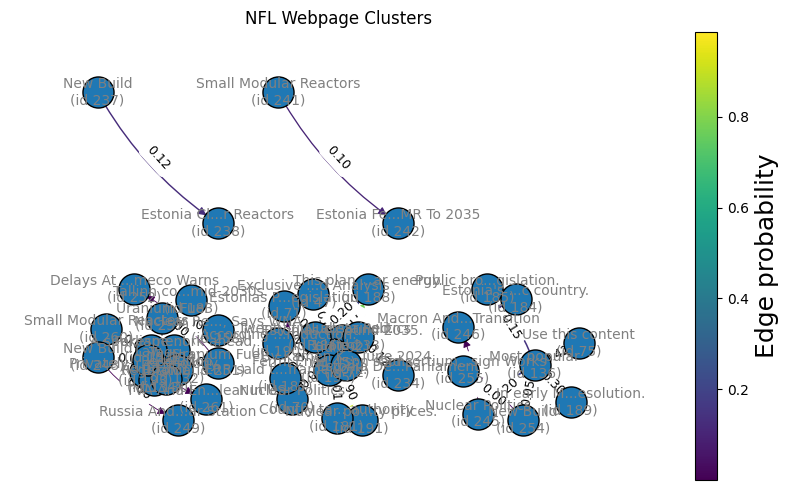

{'G': <networkx.classes.digraph.DiGraph at 0x7ee9da001b20>,
 'pos': {257: (np.float64(0.5354180382032723), np.float64(0.7821824926294317)),
  258: (np.float64(0.999497742289818), np.float64(0.6862385140223464)),
  193: (np.float64(0.395944177490327), np.float64(0.36616511899170373)),
  260: (np.float64(0.07343165153507374), np.float64(0.693300596965318)),
  194: (np.float64(0.6316544711448551), np.float64(0.5376195071449792)),
  131: (np.float64(0.44329891113424896), np.float64(0.5367562418175226)),
  132: (np.float64(0.6589226544465262), np.float64(0.3791780412778824)),
  134: (np.float64(0.4709102624734816), np.float64(0.31018707006164276)),
  133: (np.float64(0.4230367355013708), np.float64(0.45820206915005735)),
  130: (np.float64(0.5674575016699352), np.float64(0.3141089704810354)),
  261: (np.float64(0.9050658254365866), np.float64(0.1620848759147949)),
  77: (np.float64(0.5548631090521254), np.float64(0.454174420500864)),
  183: (np.float64(0.7754323632866168), np.float64(0.9149

In [ ]:
# Display the graph
textmask = np.array([True]*len(new_txts))
#textmask = filterTextMask(new_txts, "Panavision", False) #& mask = keepTopKMask(txts, 1)

numToShow=len(textmask)
for row in zip(new_edges[textmask][:numToShow], new_xpaths[textmask][:numToShow], new_txts[textmask][:numToShow], new_probs[textmask][:numToShow]):
    print(row[2])
    # print("\t", row[3])
    # print("\t", row[0])
    # print("\t", row[1])

draw_graph_from_arrays(
    txt_edge_pairs=new_txts[textmask][:numToShow],
    id_edge_pairs=new_edges[textmask][:numToShow],
    xpath_edge_pairs=new_xpaths[textmask][:numToShow],
    probs=new_probs[textmask][:numToShow],
    layout="spring",
    rankdir="LR",         # or "TB" for top→bottom
    layer_spacing=1.5,    # spread layers further
    node_spacing=10,     # spread nodes within a layer
    figsize=(8, 5),
    title="NFL Webpage Clusters",
    font_size=10,
    node_txt_colour="grey",
    node_size=500
)

['Tags' 'Estonia']
['Estonia' 'Tags']
['Tags' 'Law']
['Law' 'Tags']
['Tags' 'Regulator']
['Regulator' 'Tags']
['Tags' 'Resolution']
['Resolution' 'Tags']
['Tags' 'Parliament']
['Parliament' 'Tags']
['Fermi Energia continues to prepare the application for the national designated spatial planning and various works for procurement preparation, training and recruitment of necessary personnel and cooperation with communities, the spokesperson said.'
 'Tags']
['Tags'
 'A spokesperson for Fermi Energia told NucNet in an email that the company welcomes the parliaments resolution but there is a lot of work ahead.']
['A spokesperson for Fermi Energia told NucNet in an email that the company welcomes the parliaments resolution but there is a lot of work ahead.'
 'Tags']
['Privately-owned Estonian company Fermi Energia plans to build at least two SMRs in Estonia using GE-Hitachi BWRX-300 reactor technology.'
 'Tags']
['Related'
 'Privately-owned Estonian company Fermi Energia plans to build at lea

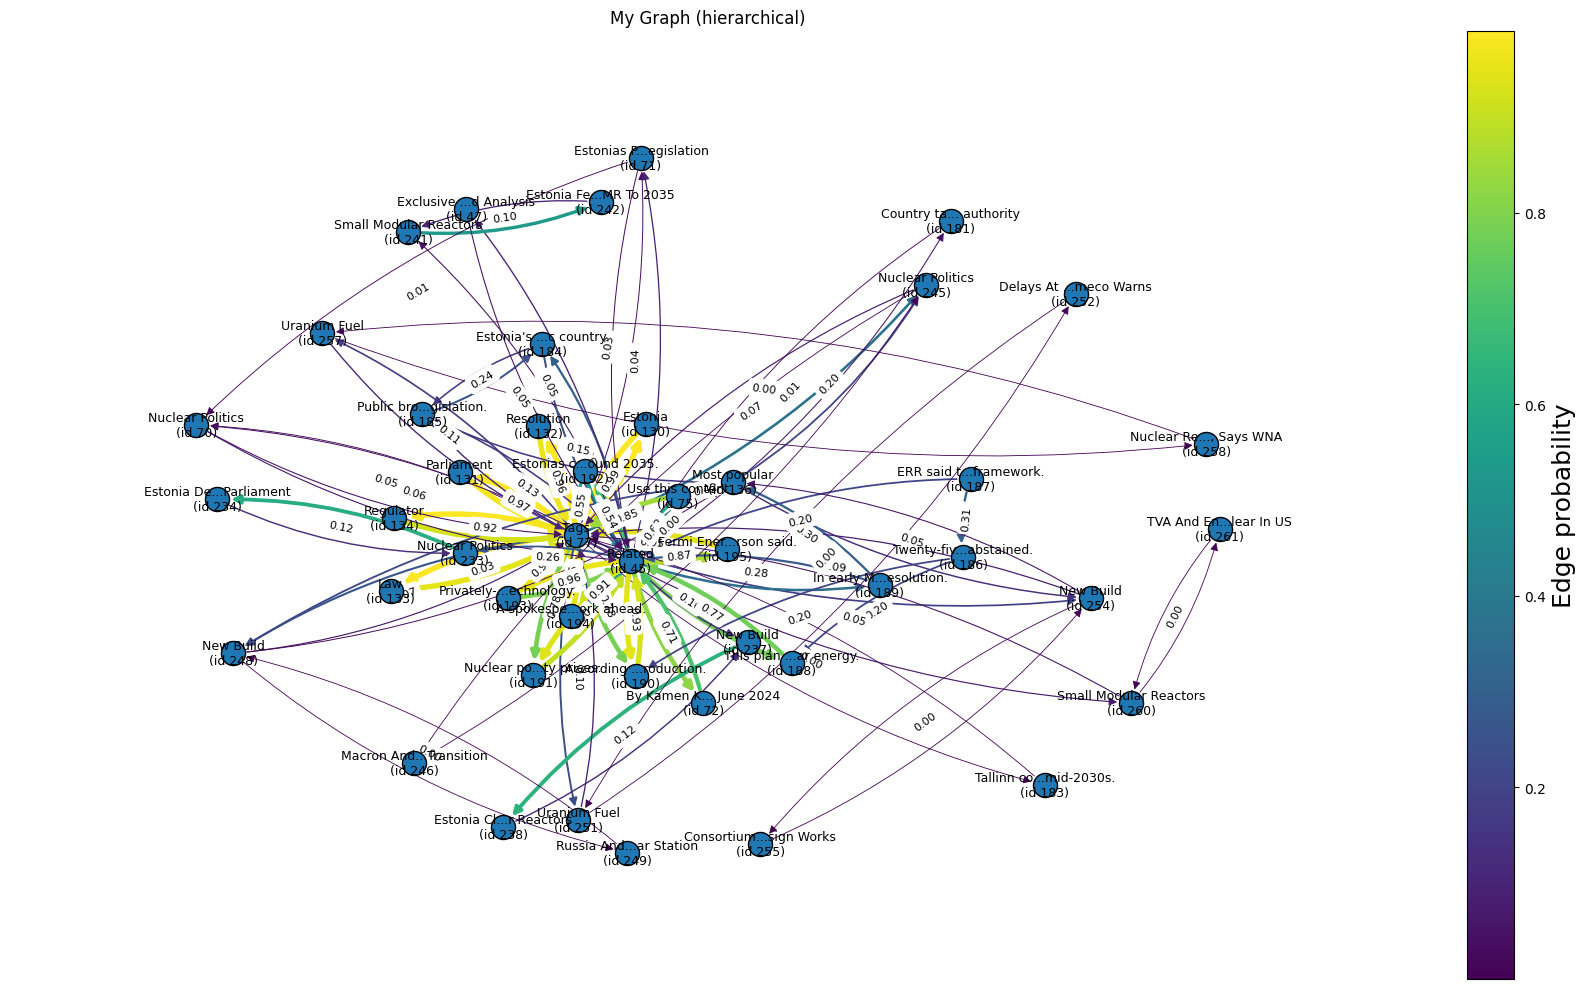

{'G': <networkx.classes.digraph.DiGraph at 0x7ee9d1f81250>,
 'pos': {77: (np.float64(0.37132437014769637), np.float64(0.4565831549285535)),
  130: (np.float64(0.4392088441800502), np.float64(0.6166207523170543)),
  133: (np.float64(0.19003293932664328), np.float64(0.37715238888604147)),
  134: (np.float64(0.1934905459597937), np.float64(0.48090907931782934)),
  132: (np.float64(0.33411689235104336), np.float64(0.6134446452264436)),
  131: (np.float64(0.25753393186253837), np.float64(0.548400745540318)),
  195: (np.float64(0.5189171399028019), np.float64(0.43649268234364946)),
  194: (np.float64(0.3658770083770572), np.float64(0.3402882103549024)),
  193: (np.float64(0.3043708439439216), np.float64(0.36667385532398805)),
  45: (np.float64(0.42466854480550903), np.float64(0.419840444241745)),
  190: (np.float64(0.42956666245439906), np.float64(0.25424511170785175)),
  191: (np.float64(0.32902810263631616), np.float64(0.2560487750417401)),
  75: (np.float64(0.4708167167182251), np.float64

In [ ]:
# Display the graph
textmask = np.array([True]*len(txts))
#textmask = filterTextMask(new_txts, "Panavision", False) #& mask = keepTopKMask(txts, 1)

numToShow=len(textmask)
for row in zip(sorted_label_index[textmask][:numToShow], xpaths[textmask][:numToShow], txts[textmask][:numToShow], probs[textmask][:numToShow]):
    print(row[2])
    # print("\t", row[3])
    # print("\t", row[0])
    # print("\t", row[1])

draw_graph_from_arrays(
    txt_edge_pairs=txts[textmask][:numToShow],
    id_edge_pairs=sorted_label_index[textmask][:numToShow],
    xpath_edge_pairs=xpaths[textmask][:numToShow],
    probs=probs[textmask][:numToShow],
    layout="spring",
    rankdir="LR",         # or "TB" for top→bottom
    layer_spacing=1.5,    # spread layers further
    node_spacing=10,     # spread nodes within a layer
    figsize=(16, 10),
    title="My Graph (hierarchical)",
)